In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f"./../")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Dict
from pathlib import Path
import random
import json

from src.qaoa_scheduling import QAOACircuit, QAOAScheduler

In [2]:
class QAOAAnalyzer:
    def __init__(self, n_vertices: int, g6_path: str, random_seed: int = None):
        if random_seed is not None:
            np.random.seed(random_seed)
        self.n_vertices = n_vertices
        self.g6_path = g6_path
        self.results_dir = Path("computed_results_greedy")
        self.results_dir.mkdir(exist_ok=True)

    def read_g6_graphs(self) -> List[nx.Graph]:
        """Read graphs from a g6 format file."""
        with open(self.g6_path, "rb") as f:
            graphs = list(nx.read_graph6(f))
        return graphs

    def analyze_graph(self, G: nx.Graph) -> Dict:
        """Analyze a single graph for QAOA scheduling metrics."""
        # Generate random gamma values in (0, 2π]
        gamma_gates = {
            (min(u, v), max(u, v)): np.random.uniform(low=0.0, high=2 * np.pi, size=1)[0]
            for u, v in G.edges()
        }
        circuit = QAOACircuit(
            n_qubits=G.number_of_nodes(), gamma_gates=gamma_gates, beta_time=1.0
        )

        # Create scheduler and get results
        scheduler = QAOAScheduler(circuit)
        lp_result = scheduler.solve_lp()
        greedy_result = scheduler.schedule_greedy()

        seqt = lp_result.total_time_before
        greedyt = greedy_result.total_time_after
        lpt = lp_result.total_time_after

        # Calculate improvement
        improvement_percentage = np.abs(lpt - greedyt) / greedyt

        return {"edges": G.number_of_edges(), "improvement": improvement_percentage}

    def get_result_path(self):
        """Get path for saving/loading results."""
        filename = f"results_greedy_v{self.n_vertices}.json"
        return self.results_dir / filename

    def save_results(self, edge_counts, means, stds):
        """Save aggregated results."""
        results = {
            "n_vertices": self.n_vertices,
            "edge_counts": edge_counts,
            "means": means,
            "stds": stds,
        }
        with open(self.get_result_path(), "w") as f:
            # Convert numpy arrays to lists for JSON serialization
            results = {
                k: v.tolist() if isinstance(v, np.ndarray) else v
                for k, v in results.items()
            }
            json.dump(results, f)

    def load_results(self):
        """Load results from JSON file."""
        try:
            with open(self.get_result_path(), "r") as f:
                results = json.load(f)
                return (
                    np.array(results["edge_counts"]),
                    np.array(results["means"]),
                    np.array(results["stds"]),
                )
        except FileNotFoundError:
            print(f"Results file for vertices={self.n_vertices} not found")
            return None, None, None

    def process_all_graphs(self, run_id) -> Tuple[np.ndarray, np.ndarray]:
        """Process all graphs and compute statistics for a single run."""
        graphs = self.read_g6_graphs()

        # Group results by edge count as we process
        edge_groups = defaultdict(list)

        for i, G in enumerate(graphs):
            result = self.analyze_graph(G)
            edge_groups[result["edges"]].append(result["improvement"])

            # No intermediate progress reporting

        # Final calculation and save
        edge_counts = np.array(sorted(edge_groups.keys()))
        means = np.array([np.mean(edge_groups[ec]) for ec in edge_counts])

        # Save results for this run
        self.save_results(edge_counts, means, run_id)
        
        return edge_counts, means


In [7]:
def sample_and_save_graphs(input_path: str, output_path: str, n_samples: int = 1000):
    """Sample graphs from g6 file and save to new file if count exceeds n_samples."""
    # Read all graphs
    with open(input_path, "rb") as f:
        graphs = list(nx.read_graph6(f))

    total_graphs = len(graphs)
    if total_graphs > n_samples:
        # Randomly sample n_samples graphs
        sampled_graphs = random.sample(graphs, n_samples)

        # Save sampled graphs
        with open(output_path, "wb") as f:
            for G in sampled_graphs:
                f.write(nx.to_graph6_bytes(G, header=False))

        print(f"Sampled {n_samples} graphs from {total_graphs} total graphs")
        return output_path
    else:
        print(f"Using all {total_graphs} graphs (less than {n_samples})")
        return input_path


def compute_all_results(vertex_range=(3, 6), n_samples: int = 1000, n_runs: int = 5):
    """Compute and save results for all vertex counts with multiple runs for statistical significance."""
    # Create output directories
    sampled_dir = Path("sampled_graphs")
    sampled_dir.mkdir(exist_ok=True)

    # Process each vertex count
    for n_vertices in range(vertex_range[0], vertex_range[1] + 1):
        print(f"\nProcessing {n_vertices} vertices...")

        # Handle original and sampled file paths
        original_path = f"./data/graphs/graph{n_vertices}c.g6"
        sampled_path = sampled_dir / f"sampled_graph{n_vertices}c.g6"

        # Sample graphs if needed and get path to use
        g6_path = sample_and_save_graphs(original_path, sampled_path, n_samples)

        # Create analyzer
        analyzer = QAOAAnalyzer(n_vertices, g6_path)
        
        # Run multiple times with different random seeds
        all_improvements = defaultdict(list)
        
        for run_id in range(n_runs):
            # Set different random seed for each run
            np.random.seed(42 + run_id)
            print(f"\nRun {run_id+1}/{n_runs} for {n_vertices} vertices...")
            
            # Process graphs for this run
            graphs = analyzer.read_g6_graphs()
            edge_improvements = defaultdict(list)
            
            for G in graphs:
                result = analyzer.analyze_graph(G)
                edge_improvements[result["edges"]].append(result["improvement"])
            
            # Compute means for this run
            edge_counts = sorted(edge_improvements.keys())
            run_means = [np.mean(edge_improvements[ec]) for ec in edge_counts]
            
            # Collect results from this run
            for ec, imp in zip(edge_counts, run_means):
                all_improvements[ec].append(imp)
        
        # Aggregate results across runs
        unique_edge_counts = sorted(all_improvements.keys())
        means = np.array([np.mean(all_improvements[ec]) for ec in unique_edge_counts])
        stds = np.array([np.std(all_improvements[ec], ddof=1) for ec in unique_edge_counts])
        
        # Save only the final aggregated results
        analyzer.save_results(np.array(unique_edge_counts), means, stds)
        
        print(f"Completed all runs for {n_vertices} vertices")


def plot_from_saved_results(vertex_range=(3, 6), n_samples: int = 1000):
    """Create plot using saved aggregate results."""
    # Set publication-quality style
    plt.rcParams.update(
        {
            "figure.figsize": (10, 6),
            "figure.dpi": 300,
            "font.size": 16,
            "font.family": "serif",
            "axes.labelsize": 18,
            "axes.titlesize": 20,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 14,
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.grid": True,
            "grid.color": "#E5E5E5",
            "grid.linewidth": 1.5,
            "lines.linewidth": 3,
            "axes.linewidth": 2,
            "xtick.major.width": 2,
            "ytick.major.width": 2,
            "xtick.major.size": 10,
            "ytick.major.size": 10,
        }
    )

    # Create figure
    fig, ax = plt.subplots()

    # Color map for different vertex counts
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    markers = ["o", "s", "^", "D", "v", "<"]

    # Plot for each vertex count
    for i, n_vertices in enumerate(range(vertex_range[0], vertex_range[1] + 1)):
        # Load saved aggregate results
        analyzer = QAOAAnalyzer(n_vertices, "")  # path not needed for loading
        edge_counts, means, stds = analyzer.load_results()
        
        if edge_counts is None:
            print(f"No results found for {n_vertices} vertices, skipping...")
            continue

        # Plot with unique color and marker
        ax.errorbar(
            edge_counts,
            means * 100,  # Convert to percentage
            yerr=stds * 100,  # SEM from multiple runs
            fmt=f"{markers[i]}-",
            capsize=4,
            capthick=1.5,
            elinewidth=1.5,
            markersize=8,
            color=colors[i],
            label=f"{n_vertices} Vertices",
            markeredgewidth=1.5,
            markeredgecolor="black",
        )

    # Customize plot
    ax.set_xlabel("Number of Edges", labelpad=10)
    ax.set_ylabel("LP vs Greedy Improvement (%)", labelpad=10)
    ax.set_title("QAOA Circuit Scheduling Comparison", pad=15)
    
    # # Ensure y-axis doesn't show negative values for percentage improvements
    # ax.set_ylim(bottom=0)

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.grid(True, linestyle="--", alpha=0.7, linewidth=1.5)
    ax.margins(x=0.05)

    # Customize legend
    ax.legend(
        frameon=True,
        edgecolor="black",
        fancybox=False,
        loc="upper left",
        ncol=2,
        columnspacing=1,
        handletextpad=0.5,
    )

    plt.tight_layout()

    # Save plot
    output_dir = Path("plots")
    output_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_dir
        / f"greedy_lp_improvement_v{vertex_range[0]}-{vertex_range[1]}_sampled{n_samples}.pdf",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

    plt.show()


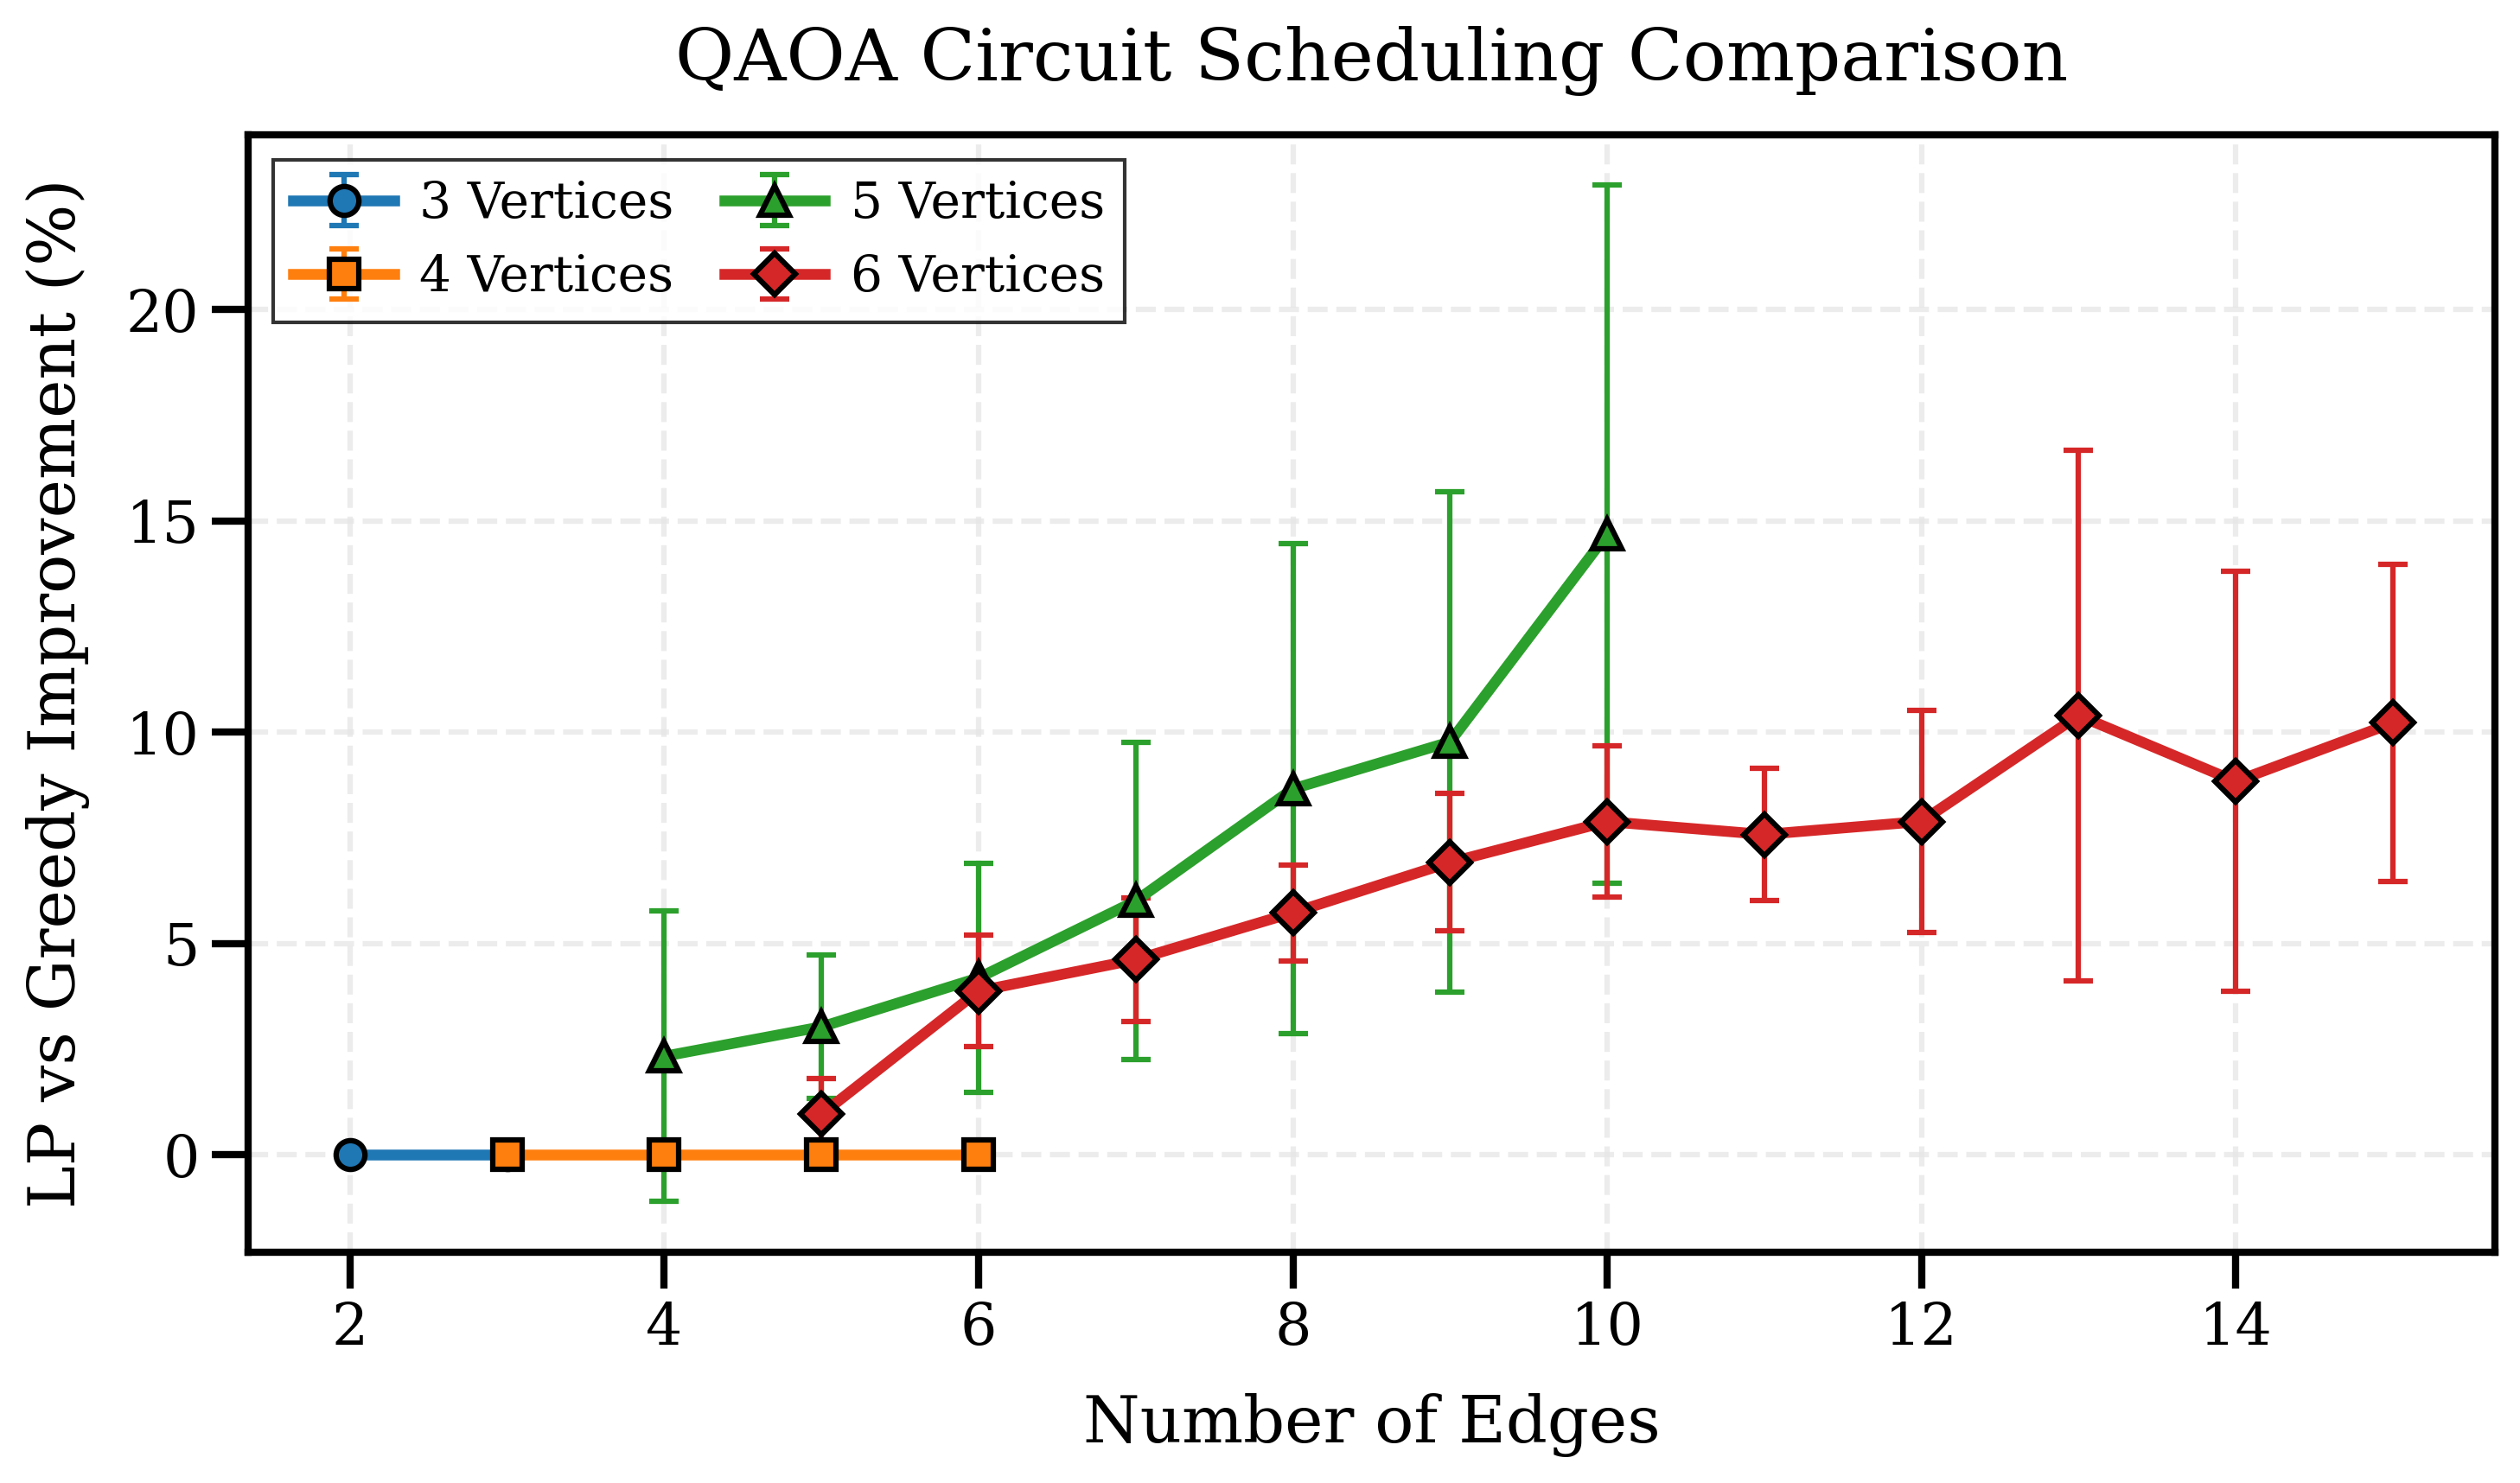

In [8]:
num_runs = 10  # Number of runs for statistical significance
# compute_all_results(vertex_range=(3, 6), n_samples=1000, n_runs=num_runs)
plot_from_saved_results(vertex_range=(3, 6), n_samples=1000)